In [1]:
# Implementation of a 2-layer MLP for FashionMNIST in PyTorch

# To install pytorch on my system (MacBook and Anaconda python distribution), I used:
# conda install pytorch torchvision -c pytorch
# search for directions for your system
# I highly recommend using conda to isolate the install from the rest of your system

# Refer to 
# https://d2l.ai/chapter_preliminaries/index.html (just chapter 2)
# https://pytorch.org/tutorials/beginner/basics/intro.html
# for PyTorch basics.

import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time, copy

In [2]:
# Load the FashionMNIST Datasets for test and training

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
training_data # a verbose description of the dataset
#len(training_data) # there are 60000 training data points
#training_data[0] # each entry in the training data set is a tuple of the image and the label
#training_data[0][0] # first entry in each training tuple is a 28-by-28 tensor of numbers in [0,1]
#training_data[0][1] # second entry is the class label (number)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

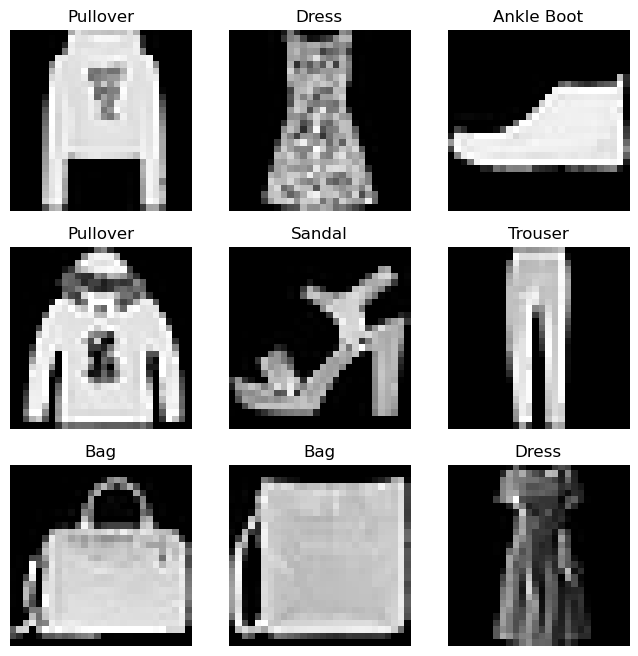

In [4]:
# Visualize the classes in FashionMNIST, straight from the PyTorch Dataset and DataLoader tutorial

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# Create a class representing our neural network by subclassing the Module class
class TwoLayerMLP(nn.Module):
   
    # in the init function we create the structure (layers) of the neural network
    def __init__(self, d, n1, k):
        super(TwoLayerMLP, self).__init__()
        self.flatten = nn.Flatten() # a layer that flattens each example in the input minibatch into a 1d tensor
        self.l1 = nn.Linear(d, n1)
        self.s1 = nn.Tanh() # try ReLU
        self.l2 = nn.Linear(n1, k)

    def forward(self, x):
        # Given a tensor x containing a minibatch of examples, so size [m, d]
        # returns a tensor containing the logits of each example
        x = self.flatten(x)
        x = self.s1(self.l1(x))
        logits = self.l2(x)
        return logits

In [6]:
# Example of applying to a single datapoint
d = 28*28
n1 = 400
k = 10

classifier = TwoLayerMLP(d, n1, k)
x = training_data[0][0]
yhat = classifier(x)
yhat.detach()

tensor([[ 0.0125, -0.0536, -0.1120, -0.1527, -0.0866,  0.0343,  0.0491, -0.2010,
          0.1185, -0.0815]])

In [7]:
# Before training, determine if we have access to a GPU 
# and use it if so (faster), otherwise fall back to CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = TwoLayerMLP(d, n1, k).to(device)
print(model)

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print('The number of parameters in the model is', num_params)

Using cpu device
TwoLayerMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (s1): Tanh()
  (l2): Linear(in_features=400, out_features=10, bias=True)
)
The number of parameters in the model is 318010


In [8]:
# Set our hyperparameters for training
lr = 1e-3
batch_size = 64
epochs = 50

# DataLoaders will return randomly shuffled minibatches in each epoch
train_loader = DataLoader(training_data, batch_size=batch_size, 
                              shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# set the loss function
criterion = nn.CrossEntropyLoss() # takes logits and true class as input; computes the MEAN loss over a minibatch by default

In [9]:
# Does one epoch of training. Assumes the model is in training mode

def train_epoch(dataloader, model, criterion, optimizer, verbose=True):
    
    size = len(dataloader.dataset)

    for batchnum, (X, y) in enumerate(dataloader):
        # Compute prediction and loss on the minibatch
        yhat = model(X) # this calls forward on the minibatch (do not call forward directly)
        loss = criterion(yhat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0 and verbose:
            # report the loss on current minibatch every 100 minibatches
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
# Computes loss and accuracy on the validation set. Assumes the model is in eval mode

def validate(dataloader, model, criterion, verbose=True):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # we don't want to accumulate the gradients during validation
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss

In [10]:
# Train

val_accs = np.array([0.0]*epochs)
val_losses = copy.deepcopy(val_accs)
train_accs = copy.deepcopy(val_accs)
train_losses = copy.deepcopy(val_accs)
all_time = 0 # records time spent training and evaluating model
lowest_error = np.inf
best_epoch = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    curtime = time.time()
    
    model.train() # turn model to train mode (for dropout, etc)
    train_epoch(train_loader, model, criterion, optimizer, verbose=True)
    
    model.eval() # turn model to evaluation mode (for dropout, etc)
    train_accs[t], train_losses[t] = validate(train_loader, model, criterion, verbose=False)
    val_accs[t], val_losses[t] = validate(test_loader, model, criterion, verbose=True)
    
    epoch_time = time.time() - curtime
    all_time += epoch_time

    # Store the parameters of the best performing model
    # Note: we use the losses to determine "best" model; 
    # this is not a defininitive choice of metric, e.g. you could use accuracy
    # Note: we could also store the state_dict for the optimizer, and
    # resume optimization from the best model
    if val_losses[t] < lowest_error:
        print("This is currently the best performing model, saving it")
        lowest_error = val_losses[t]
        best_epoch = t
        torch.save(model.state_dict(), 'best_model_weights.pth')
    
    print(f"Epoch took {epoch_time:>0.1f} seconds (training + evaluation) \n")
    
print(f"Done training! Took {all_time:>0.1f} seconds")

Epoch 1
-------------------------------
loss: 2.298798  [    0/60000]
loss: 0.656124  [ 6400/60000]
loss: 0.691964  [12800/60000]
loss: 0.376741  [19200/60000]
loss: 0.684079  [25600/60000]
loss: 0.361475  [32000/60000]
loss: 0.376135  [38400/60000]
loss: 0.567616  [44800/60000]
loss: 0.352524  [51200/60000]
loss: 0.406347  [57600/60000]
Validation Error: 
 Accuracy: 84.7%, Avg loss: 0.423246
This is currently the best performing model, saving it
Epoch took 8.4 seconds (training + evaluation) 

Epoch 2
-------------------------------
loss: 0.345795  [    0/60000]
loss: 0.305819  [ 6400/60000]
loss: 0.353968  [12800/60000]
loss: 0.293729  [19200/60000]
loss: 0.472512  [25600/60000]
loss: 0.335803  [32000/60000]
loss: 0.437546  [38400/60000]
loss: 0.323705  [44800/60000]
loss: 0.364099  [51200/60000]
loss: 0.390374  [57600/60000]
Validation Error: 
 Accuracy: 85.3%, Avg loss: 0.404032
This is currently the best performing model, saving it
Epoch took 8.0 seconds (training + evaluation) 



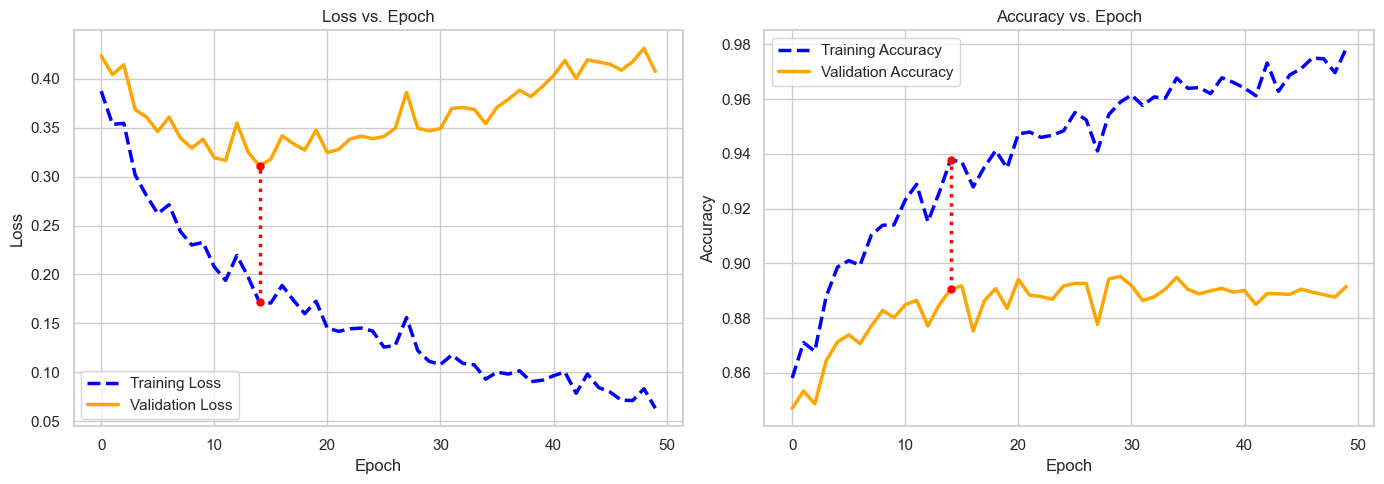

In [20]:
# Visualize convergence and generalization gap

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': np.array(range(epochs)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Training Accuracy': train_accs,
    'Validation Accuracy': val_accs
})

# Set the Seaborn style
sns.set(style='whitegrid')

# Create a figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the losses
sns.lineplot(x='Epoch', y='Training Loss', data=data, ax=axes[0], label='Training Loss', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Loss', data=data, ax=axes[0], label='Validation Loss', 
             color='orange', linewidth=2.5, linestyle='-')
axes[0].set_title('Loss vs. Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

# Plot the accuracies
sns.lineplot(x='Epoch', y='Training Accuracy', data=data, ax=axes[1], label='Training Accuracy', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Accuracy', data=data, ax=axes[1], label='Validation Accuracy', 
             color='orange', linewidth=2.5, linestyle='-')
axes[1].set_title('Accuracy vs. Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_xlabel('Epoch')

# Add a large red dot at epoch of best model for losses and accuracies
axes[0].plot(best_epoch, train_losses[best_epoch], 'o', color='red', markersize=5)
axes[0].plot(best_epoch, val_losses[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, train_accs[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, val_accs[best_epoch], 'o', color='red', markersize=5)

# Draw a vertical line between training and validation losses and accuracies at epoch w/ best model
axes[0].vlines(x=best_epoch, ymin=train_losses[best_epoch], ymax=val_losses[best_epoch], 
               color='red', linestyle=':', linewidth=2.5)
axes[1].vlines(x=best_epoch, ymin=val_accs[best_epoch], ymax=train_accs[best_epoch],  
               color='red', linestyle=':', linewidth=2.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [12]:
# To use the model in practice, e.g.

x, y = test_data[32]
model.eval()
yhat = model(x).detach()
yhat = yhat.argmax().item()

print(f'True class: {y}, Predicted class: {yhat}')

True class: 3, Predicted class: 3


In [13]:
# Save (pickle) the model parameters to file 
torch.save(model.state_dict(), 'model_weights.pth')

# Initialize a model using saved parameters
model2 = TwoLayerMLP(d, n1, k) # have to initialize model to have same architecture
model2.load_state_dict(torch.load('best_model_weights.pth', weights_only=True))

model2.eval() # always use this before using a model at inference time

TwoLayerMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (s1): Tanh()
  (l2): Linear(in_features=400, out_features=10, bias=True)
)